In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
train0 = pd.read_pickle('D:\\CS760\\pj\\train_set_0.pkl')
train1 = pd.read_pickle('D:\\CS760\\pj\\train_set_1.pkl')
train2 = pd.read_pickle('D:\\CS760\\pj\\train_set_2.pkl')
train_set = pd.concat([train0,train1], ignore_index=True)
training = pd.concat([train_set,train2], ignore_index=True)

In [3]:
testset =  pd.read_pickle('D:\\CS760\\pj\\train_set_2.pkl')

In [4]:
device = ['Chrome','Firefox','Opera','Safari','Edge','Android Browser','Seznam','Samsung Internet','Internet Explorer',
          'UC Browser','YaBrowser','Amazon Silk','BlackBerry','Coc Coc','Mozilla','Maxthon', 'Nintendo Browser',
         'Playstation Vita Browser', 'Nokia Browser','MRCHROME','SeaMonkey','Puffin']

In [5]:
training['device_browser'].replace({'Opera Mini':'Opera', 'Safari (in-app)':'Safari', 'Android Webview':'Android Browser',
                                   'Mozilla Compatible Agent':'Mozilla'}, inplace=True)
training.loc[~training['device_browser'].isin(device),'device_browser']='others'

In [6]:
testset['device_browser'].replace({'Opera Mini':'Opera', 'Safari (in-app)':'Safari', 'Android Webview':'Android Browser',
                                   'Mozilla Compatible Agent':'Mozilla'}, inplace=True)
testset.loc[~testset['device_browser'].isin(device),'device_browser']='others'

In [7]:
trainset = training.sample(frac=3/4,random_state=101)
validset = training.loc[~training.index.isin(trainset.index), :]

In [8]:
def ordinal(data):
    categorical = ['channelGrouping','device_browser','device_operatingSystem','geoNetwork_country']
    boolean = ['trafficSource_adwordsClickInfo.isVideoAd','trafficSource_isTrueDirect']
    for col in categorical:
        attributes = data[col].unique()
        d = dict(enumerate(attributes,start=1))
        new = dict((v,k) for k,v in d.items())
        data[col].replace(new,inplace = True)
    for col in boolean:
        data[col].replace({True:1,False:0},inplace=True)
    return data

def standardize(TrainSet,TestSet):
    standard=np.array(TrainSet)
    standard_test=np.array(TestSet)
    mean_array=np.mean(standard,axis=0)
    stdev=np.std(standard,axis=0,ddof=1)
    if stdev==0:
        stdev=1
    outcome = (standard_test - mean_array) / stdev
    return outcome

In [9]:
def GetData(A, B):
    dataset1 = A.copy()
    dataset2 = B.copy()
    
    ID = dataset1[['fullVisitorId']]
    # y = log(1+revenue)
    dataset1['totals_transactionRevenue'] = np.log(dataset1['totals_transactionRevenue']+1)
    dataset2['totals_transactionRevenue'] = np.log(dataset2['totals_transactionRevenue']+1)
    
    # ordinal encoding categorical features  
    dataset1 = ordinal(dataset1)
    
    # standardize numerical features
    numerical = ['totals_hits','totals_pageviews','totals_sessionQualityDim','totals_timeOnSite',
                 'totals_transactionRevenue','totals_transactions']
    for col in numerical:
        #standardize dataset1 based on dataset2
        dataset1[col]=standardize(dataset2[col],dataset1[col]) 
    # load y
    train_y = dataset1[['totals_transactionRevenue']]
    
    y = torch.tensor(train_y.values)
    # load x
    train_x = dataset1.drop(['totals_transactionRevenue','fullVisitorId','visitStartTime'], axis=1)
    x = torch.tensor(train_x.to_numpy(dtype=np.float))   
    return x,y,ID    

In [10]:
train_x, train_y, train_ID = GetData(trainset,trainset)
valid_x, valid_y, valid_ID = GetData(validset,trainset)

In [11]:
test_x, test_y, test_ID = GetData(testset, trainset)

In [12]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, 1)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_softmax = F.softmax(self.linear1(x.float()))
        y_pred = self.linear2(h_softmax)
        return y_pred

In [13]:
def train(model, x, y,criterion,optimizer):
    """
   train NN
    """
    model.train()
    y_pred = model(x)
    loss = criterion(y_pred.float(), y.float())
    print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def valid(model, x_valid, y_valid,criterion):
    """
    test NN
    """
    model.eval()
    y_pred = model(x_valid)
    loss = criterion(y_pred.float(), y_valid.float())
    #print(loss.item())
    return loss.item(),y_pred

In [14]:
model1 = TwoLayerNet(train_x.shape[1], 8)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.1)
loss_train1=[]

for i in range(100):
    print(i,' ', end='')
    loss_train1.append(train(model1,train_x,train_y,criterion,optimizer))

loss_valid1 = valid(model1, valid_x, valid_y,criterion)[0]

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.9904841780662537
1  0.9353324174880981
2  0.8918799161911011
3  0.853698194026947
4  0.8191990852355957
5  0.7864000201225281
6  0.7542471289634705
7  0.7201879620552063
8  0.6870672702789307
9  0.6580368876457214
10  0.6247867941856384
11  0.5945205092430115
12  0.5658140182495117
13  0.5377687215805054
14  0.5101129412651062
15  0.48284682631492615
16  0.4560730755329132
17  0.42998018860816956
18  0.40465760231018066
19  0.3805941939353943
20  0.35761117935180664
21  0.3356233835220337
22  0.31439656019210815
23  0.29408344626426697
24  0.27474865317344666
25  0.2565249502658844
26  0.23865440487861633
27  0.22193466126918793
28  0.20607249438762665
29  0.19109082221984863
30  0.17690619826316833
31  0.16363577544689178
32  0.15108463168144226
33  0.13923342525959015
34  0.12807582318782806
35  0.1175902858376503
36  0.1077117770910263
37  0.09852699935436249
38  0.09004879742860794
39  0.08215408772230148
40  0.07483755797147751
41  0.06809855997562408
42  0.06188318505883217
43 

In [15]:
model2 = TwoLayerNet(train_x.shape[1], 4)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.1)
loss_train2=[]

for i in range(100):
    print(i,' ', end='')
    loss_train2.append(train(model2,train_x,train_y,criterion,optimizer))
    
loss_valid2=valid(model2, valid_x, valid_y,criterion)[0]

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1.1026818752288818
1  0.9187169671058655
2  0.9018293619155884
3  0.9056375026702881
4  0.8845649361610413
5  0.8486343622207642
6  0.8136587142944336
7  0.7878790497779846
8  0.7704170346260071
9  0.7541673183441162
10  0.7333834171295166
11  0.7075651288032532
12  0.6795164346694946
13  0.6528739929199219
14  0.6292109489440918
15  0.6078596115112305
16  0.5882741808891296
17  0.5685914754867554
18  0.549637496471405
19  0.5252511501312256
20  0.5036460161209106
21  0.4840351641178131
22  0.4665123224258423
23  0.4501062035560608
24  0.4334579110145569
25  0.41605693101882935
26  0.3981999158859253
27  0.3808112144470215
28  0.36456727981567383
29  0.34948036074638367
30  0.3350072503089905
31  0.32054397463798523
32  0.30587100982666016
33  0.29124894738197327
34  0.27718859910964966
35  0.26399582624435425
36  0.25161224603652954
37  0.23967313766479492
38  0.22787299752235413
39  0.2162761688232422
40  0.2051418125629425
41  0.19465811550617218
42  0.18474452197551727
43  0.175357

In [16]:
model3 = TwoLayerNet(train_x.shape[1], 16)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.1)
loss_train3=[]

for i in range(100):
    print(i,' ', end='')
    loss_train3.append(train(model3,train_x,train_y,criterion,optimizer))
    
loss_valid3=valid(model3, valid_x, valid_y,criterion)[0]

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.9970621466636658
1  1.0165395736694336
2  0.9570900201797485
3  0.9558534622192383
4  0.9068759083747864
5  0.8718059062957764
6  0.8380719423294067
7  0.8077114224433899
8  0.7786732912063599
9  0.7537415027618408
10  0.7285814881324768
11  0.6997298002243042
12  0.6717760562896729
13  0.6462860703468323
14  0.6212331652641296
15  0.5945160388946533
16  0.5675985217094421
17  0.541865885257721
18  0.518423318862915
19  0.496246337890625
20  0.4753206968307495
21  0.45042863488197327
22  0.4278968274593353
23  0.4067516624927521
24  0.3868953585624695
25  0.36792030930519104
26  0.34905919432640076
27  0.3307071626186371
28  0.3131157159805298
29  0.2961975038051605
30  0.27961069345474243
31  0.26333722472190857
32  0.24765899777412415
33  0.23268915712833405
34  0.21873176097869873
35  0.20537452399730682
36  0.19261042773723602
37  0.18041275441646576
38  0.16886308789253235
39  0.158023864030838
40  0.14771431684494019
41  0.13785147666931152
42  0.1284894198179245
43  0.11970522

In [17]:
model4 = TwoLayerNet(train_x.shape[1], 32)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.1)
loss_train4=[]

for i in range(100):
    print(i,' ', end='')
    loss_train4.append(train(model4,train_x,train_y,criterion,optimizer))


loss_valid4=valid(model4, valid_x, valid_y,criterion)[0]

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1.0227056741714478
1  1.014841079711914
2  0.9707189202308655
3  0.9275016188621521
4  0.916351318359375
5  0.8907872438430786
6  0.8615211844444275
7  0.8371669054031372
8  0.8123421669006348
9  0.7850006818771362
10  0.7565147876739502
11  0.7276804447174072
12  0.6992831230163574
13  0.6719701886177063
14  0.6457846760749817
15  0.6196054220199585
16  0.5927385091781616
17  0.5660525560379028
18  0.5402862429618835
19  0.5151940584182739
20  0.4906826913356781
21  0.46656444668769836
22  0.44361254572868347
23  0.4209638833999634
24  0.40034955739974976
25  0.37892717123031616
26  0.3579043745994568
27  0.33796021342277527
28  0.31900373101234436
29  0.30060601234436035
30  0.28298643231391907
31  0.266269713640213
32  0.2501252591609955
33  0.2344219982624054
34  0.21935926377773285
35  0.20522893965244293
36  0.19195328652858734
37  0.17917446792125702
38  0.166878342628479
39  0.155265212059021
40  0.14428389072418213
41  0.13384439051151276
42  0.12402761727571487
43  0.11478022

Text(0.5, 1.0, '2 layer network: nodes number VS loss')

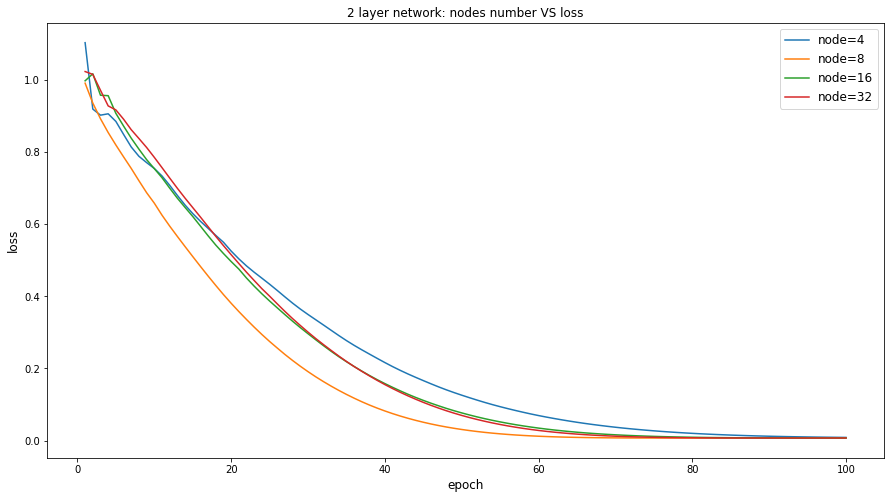

In [18]:
fig,ax = plt.subplots(figsize=(15,8))

ax.plot(range(1,101),loss_train2,label = 'node=4')
ax.plot(range(1,101),loss_train1,label = 'node=8')
ax.plot(range(1,101),loss_train3,label = 'node=16')
ax.plot(range(1,101),loss_train4,label = 'node=32')
ax.set_xlabel('epoch',fontsize='large')
ax.set_ylabel('loss',fontsize='large')
ax.legend(fontsize='large')
ax.set_title('2 layer network: nodes number VS loss')

In [21]:
print('Model 1: 2 layer network with 8 nodes in each hidden layer, validation MSE LOSS = ', loss_valid1)
print('Model 2: 2 layer network with 4 nodes in each hidden layer, validation MSE LOSS = ', loss_valid2)
print('Model 3: 2 layer network with 16 nodes in each hidden layer, validation MSE LOSS = ', loss_valid3)
print('Model 4: 2 layer network with 32 nodes in each hidden layer, validation MSE LOSS = ', loss_valid4)

Model 1: 2 layer network with 8 nodes in each hidden layer, validation MSE LOSS =  0.006486271973699331
Model 2: 2 layer network with 4 nodes in each hidden layer, validation MSE LOSS =  0.00813909713178873
Model 3: 2 layer network with 16 nodes in each hidden layer, validation MSE LOSS =  0.006463049445301294
Model 4: 2 layer network with 32 nodes in each hidden layer, validation MSE LOSS =  0.006446004845201969


In [22]:
def restore(pred_y,trainset):
    standard =trainset[['totals_transactionRevenue']].values
    standard = np.log(standard+1)
    mean=np.mean(standard,axis=0)
    mean = mean[0]

    stdev=np.std(standard,axis=0,ddof=1)
    stdev = stdev[0]

    y = pred_y*stdev + mean
    y=y.detach().numpy()
    pred_revenue = np.exp(y)-1
    pred_revenue = np.where(pred_revenue<0.01,0,pred_revenue)
    return y, pred_revenue

In [24]:
test_loss, test_pred = valid(model4, test_x, test_y, criterion)

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [25]:
r1,r2 = restore(test_pred,trainset)

In [26]:
test_ID['pred_revenue']=r2
test_ID['true_revenue']=testset['totals_transactionRevenue']
test_ID

,fullVisitorId,pred_revenue,true_revenue
138892,5010032653131027513,0.014687,0.0
138893,8224664698359594721,0.000000,0.0
138894,4765296453494895643,0.000000,0.0
138895,4903219059240129204,0.000000,0.0
138896,109606899040654516,0.000000,0.0
138897,7340942839601994731,0.000000,0.0
138898,2596624436473347088,0.000000,0.0
138899,3093566724126253413,0.000000,0.0
138900,4097555294720182704,0.000000,0.0
138901,0272639494387064411,0.000000,0.0


In [27]:
outcome = test_ID.groupby(['fullVisitorId']).sum()
outcome['pred_revenue']=np.log(outcome['pred_revenue']+1)
outcome['true_revenue']=np.log(outcome['true_revenue']+1)

In [28]:
outcome

,pred_revenue,true_revenue
fullVisitorId,,
0000027376579751715,0.000000,0.0
0000039460501403861,0.000000,0.0
0000040862739425590,0.000000,0.0
0000049363351866189,0.000000,0.0
0000062267706107999,0.000000,0.0
0000085059828173212,0.000000,0.0
0000114156543135683,0.000000,0.0
0000117255350596610,0.000000,0.0
0000130646294093000,0.000000,0.0


In [29]:
outcome[outcome['true_revenue']>0]

,pred_revenue,true_revenue
fullVisitorId,,
0001376836098133431,17.855970,18.197412
0002871498069867123,17.855970,18.383498
0006911334202687206,17.855970,17.884537
0007617910709180468,17.855970,16.759423
0010295111715775250,17.855970,14.686804
0010664124684883628,18.549118,17.883511
0012224893830398338,17.855970,16.677711
0012561433643490595,17.855970,15.294840
0014262055593378383,17.855970,16.790019
